In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

In [3]:
x = df.drop('energy', axis=1)
y = df['energy']


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


In [5]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [7]:
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)


GradientBoostingRegressor()

In [15]:
y_pred = gbr.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [16]:
from sklearn.dummy import DummyRegressor

In [17]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score

accuracy = gbr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

my_scores = []

mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)


mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)




mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)


mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)




print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")
    

Accuracy: 85.74%
Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       8818126635621.430    62012735682363.141   0.142     
R2                        0.857                -0.003               -314.107  
MAE                       2026362.131          6757202.973          0.300     
Ratio of mae over mean value of y: 0.120


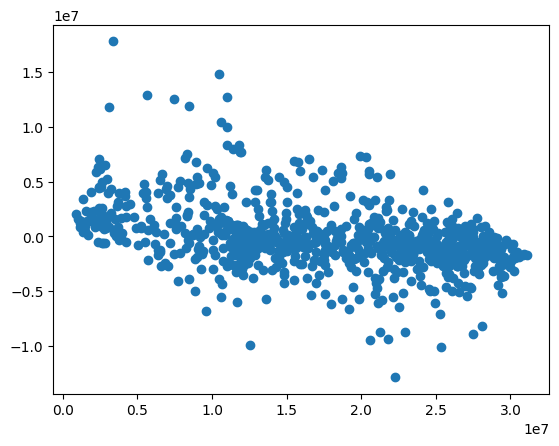

In [19]:
plt.scatter(y_test, y_pred - y_test)
# plt.scatter(y_test, y_pred_dummy - y_test)
plt.show()

## Pt.2 Hyper parameter tuning with cross validation

In [ ]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 1000, num = 100)]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
max_depth = [int(x) for x in np.linspace(1, 100, num = 20)]
loss=['squared_error','absolute_error', 'huber', 'quantile']
min_samples_split = [2, 5, 10, 15, 20]

param_grid = {
    'n_estimators': n_estimators,
    'learning_rate': learning_rate,
    'max_depth': max_depth,
    'loss': loss,
    'min_samples_split': min_samples_split
}

gbr_random = RandomizedSearchCV(estimator = gbr, param_distributions = param_grid, n_iter = 200, cv = 3, random_state=56, n_jobs = -1, scoring='neg_mean_absolute_error')

gbr_random.fit(X_train, y_train)

print(f"{'The best parameters are':<35} {gbr_random.best_params_}")
print(f"{'The best score is':<35} {gbr_random.best_score_}")
              